In [1]:
using Falcons
using Healpix
using Plots
using NPZ
using StatsBase
using BenchmarkTools
using PyCall
using TickTock
using Base.Threads
using StaticArrays
using PyPlot
using Formatting
using ReferenceFrameRotations
using LinearAlgebra
using ProgressMeter
using HDF5
using Interpolations

hp = pyimport("healpy")
np = pyimport("numpy")
pd = pyimport("pandas")

PyObject <module 'pandas' from '/home/cmb/yusuket/.julia/conda/3/lib/python3.8/site-packages/pandas/__init__.py'>

In [2]:
function get_2Ddata(data, Nx, Ny)
    beam2d = reshape(data["copol"], (Ny, Nx))'
    theta = deg2rad.(reshape(data["theta"], (Ny, Nx)))'
    phi = deg2rad.(reshape(data["phi"], (Ny, Nx)))'
    x = rad2deg.(theta .* cos.( phi ))
    y = rad2deg.(theta .* sin.( phi ))
    return (beam2d, x, y)
end

function symmetrizer(psi_in_ipix, beam2d, Nx, Ny)
    beam_reshape = [beam2d'[1:Nx+1,:] rot180(beam2d'[Nx+1:end,:])]
    
    SIZE = size(beam_reshape)
    beam_sym = zeros(SIZE[1], SIZE[2])
    n = length(psi_in_ipix)
    
    for i in eachindex(psi_in_ipix)
        rot_i = Int(round(rad2deg(psi_in_ipix[i])))
        #@show rot_i
        #@show rad2deg(psi_in_ipix[i])
        beam_sym .+= circshift(beam_reshape, (0, 2rot_i))
    end
    
    beam_sym = beam_sym ./ n
    beam_reconst_sym = [beam_sym[:,1:Nx] ;reverse(rot180(beam_sym[1:end-1,Nx+1:Ny-1]), dims=2)]'
    
    return beam_reconst_sym
end

@. dBi(x) =10log10(x)

dBi (generic function with 1 method)

In [3]:
idx = 100
dir = "/group/cmb/litebird/usr/ytakase/psi_db/3_30/"
file = h5open(dir * "idx=$idx.h5", "r")
psi_in_ipix = read(file,"psi/1");

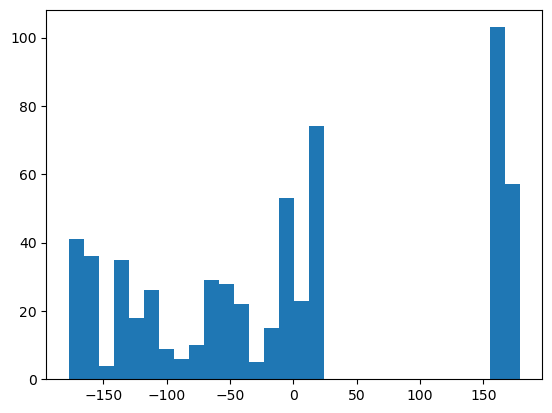

In [4]:
plt.hist(rad2deg.(psi_in_ipix), bins=30);

In [5]:
data = npzread("../../data/beamfile/MFT_88.5GHz_000.0_166.7_xpol_v2.npz")
Nx = 360
Ny = 721

721

In [6]:
beam2d, x, y = get_2Ddata(data, Nx, Ny);

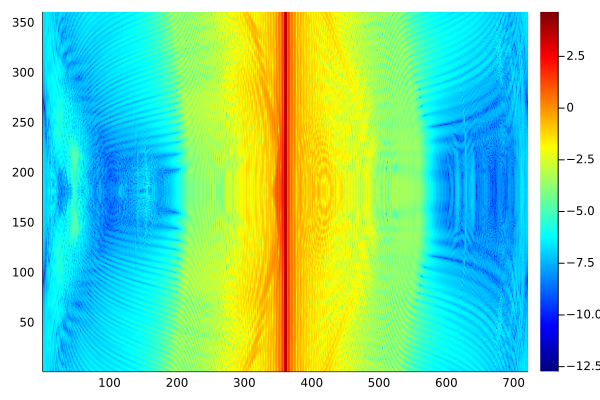

In [7]:
heatmap(log10.(beam2d), c=:jet)

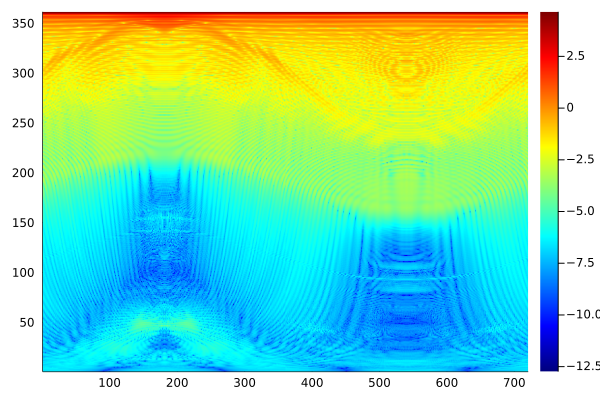

In [8]:
beam_reshape = [beam2d'[1:Nx+1,:] rot180(beam2d'[Nx+1:end,:])]
#rot_i = Int(round(rad2deg( ((90) ) ) ) )
#beam_reshape = circshift(beam_reshape, (0, rot_i))
#beam_reshape = [beam_reshape[:,1:Nx] ;reverse(rot180(beam_reshape[1:end-1,Nx+1:Ny-1]), dims=2)]'
heatmap(log10.(beam_reshape), c=:jet)

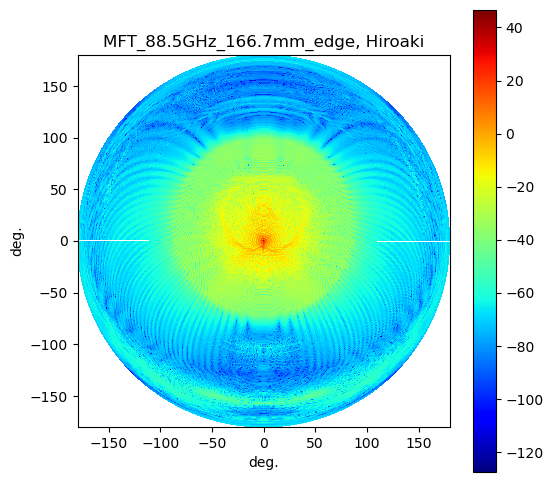

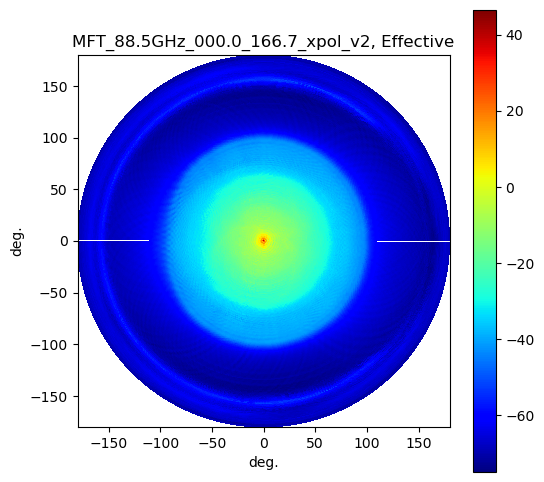

PyObject <matplotlib.colorbar.Colorbar object at 0x7f348be568e0>

In [9]:
plt.figure(figsize=(6,6))
#plt.title("MFT_88.5GHz_000.0_166.7_xpol_v2")
plt.title("MFT_88.5GHz_166.7mm_edge, Hiroaki")
plt.xlabel("deg.")
plt.ylabel("deg.")
plt.pcolormesh(x, y, 10log10.(beam2d), cmap = "jet" )
plt.axes().set_aspect("equal")
plt.colorbar( orientation ="vertical")

beam2d_sym = symmetrizer(psi_in_ipix, beam2d, Nx, Ny)
plt.figure(figsize=(6,6))
plt.title("MFT_88.5GHz_000.0_166.7_xpol_v2, Effective")
plt.xlabel("deg.")
plt.ylabel("deg.")
plt.pcolormesh(x, y, 10log10.(beam2d_sym), cmap = "jet" )
plt.axes().set_aspect("equal")
plt.colorbar( orientation ="vertical")

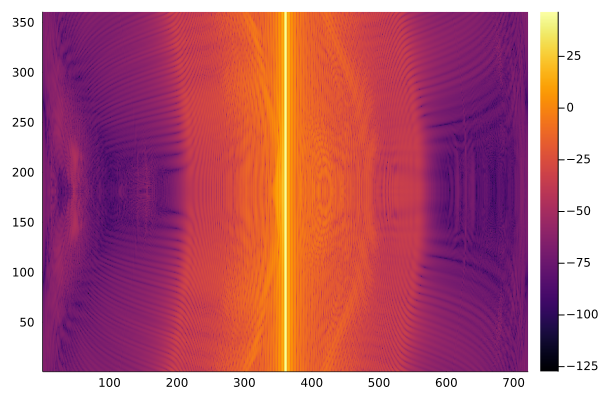

In [10]:
heatmap(dBi(beam2d))

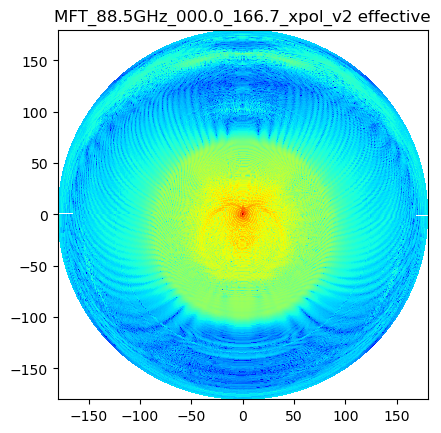

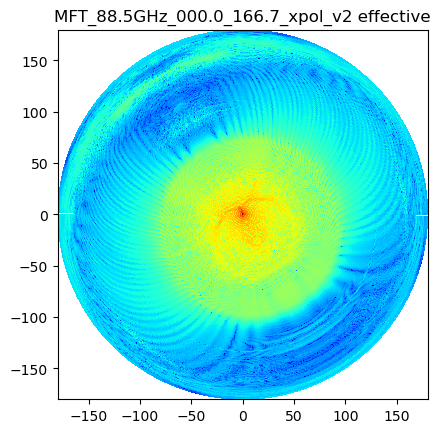

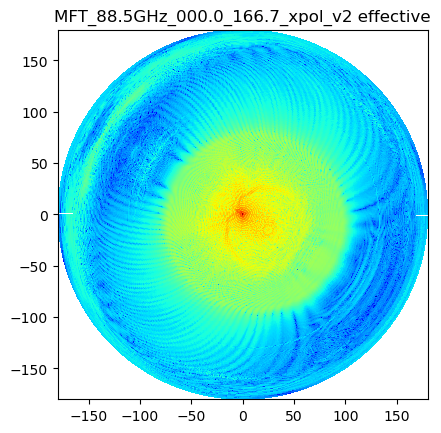

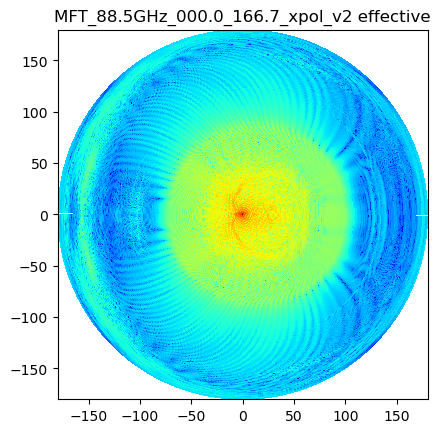

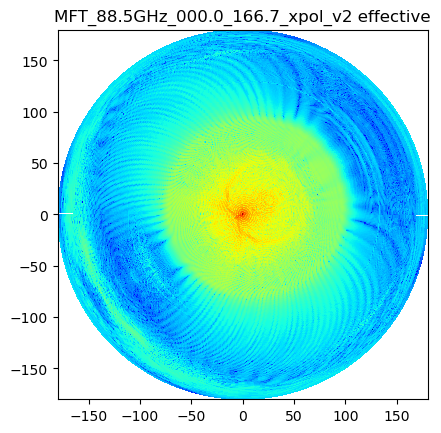

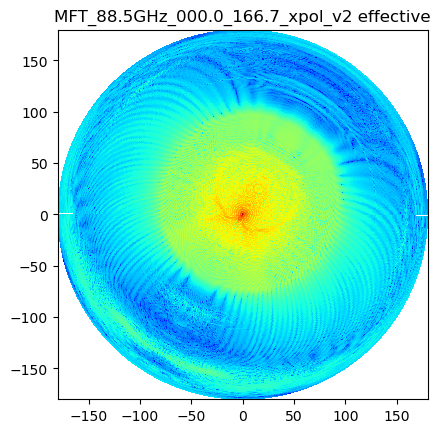

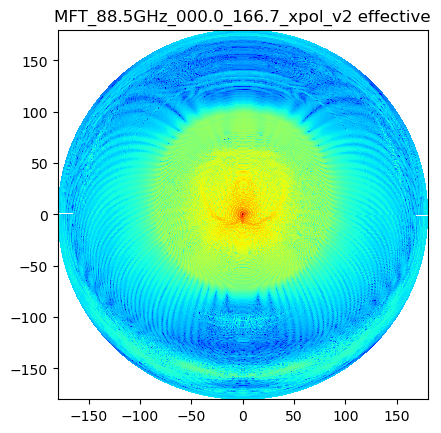

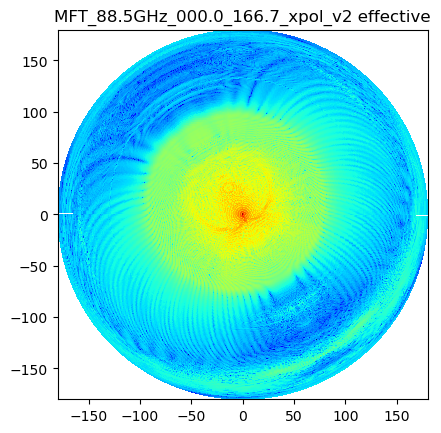

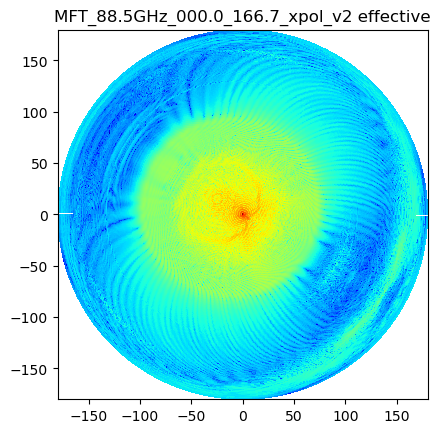

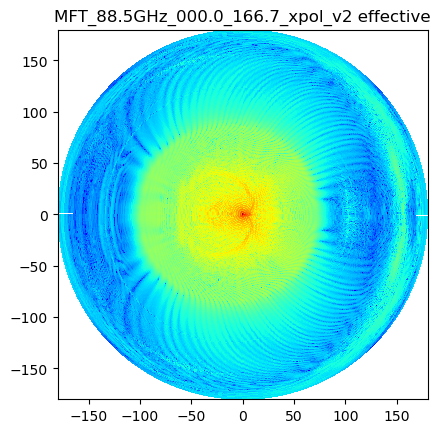

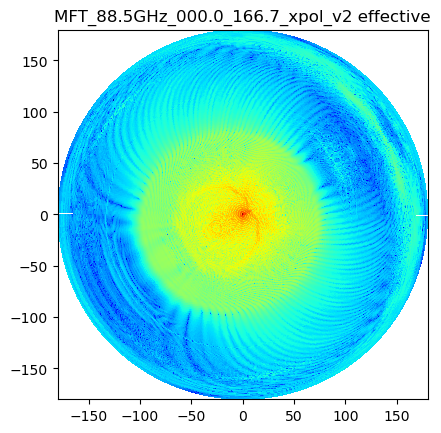

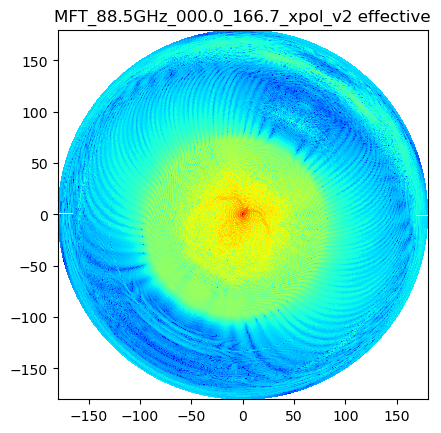

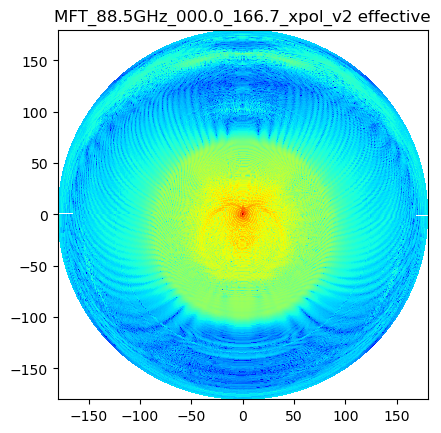

In [11]:
for i in -180:30:180
    rotbeam = symmetrizer([π/180].*i, beam2d, Nx, Ny)
    plt.figure()
    plt.title("MFT_88.5GHz_000.0_166.7_xpol_v2 effective")
    plt.pcolormesh(x, y, 10log10.(rotbeam), cmap = "jet" )
    plt.axes().set_aspect("equal")
    #pp = plt.colorbar( orientation ="vertical")
end
#gif(anim, format("./cheack_beam_rotation.gif"), fps=10)

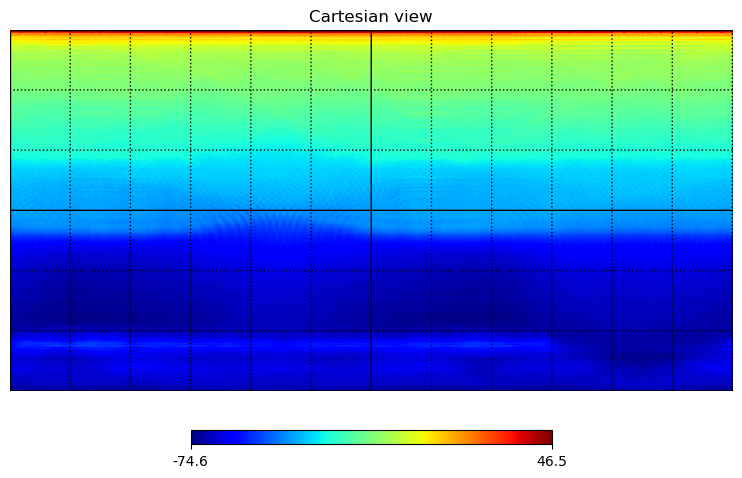

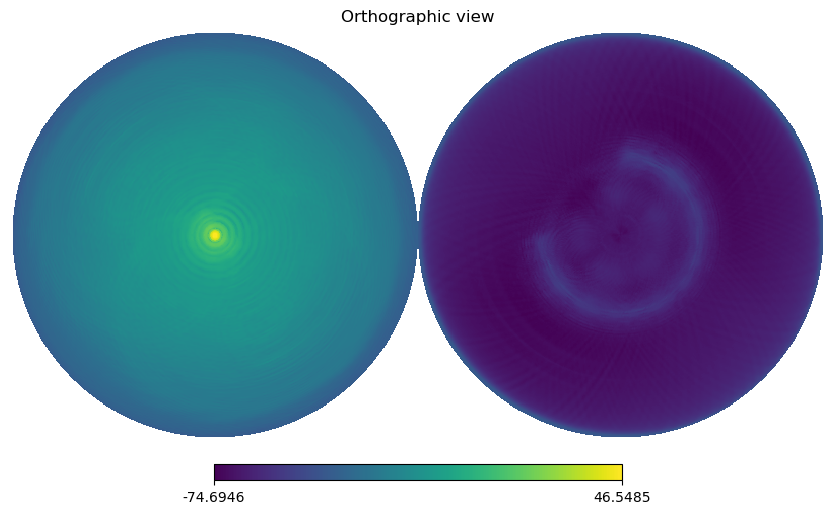

In [15]:
function gen_beammap(res::Resolution, beam2d, target_pixel)
    #beam_reshape = rotl90([beam2d'[1:361,:] rotl90(beam2d'[361:end,:],2)],2)
    beam_reshape = rot180([ beam2d'[1:Nx+1,:] reverse(rot180(beam2d'[Nx+1:end,:]), dims=2) ])
    #itp = interpolate(beam_reshape, BSpline(Cubic(InPlace(OnCell()))))
    itp = Interpolations.interpolate(beam_reshape, BSpline(Linear()))
    
    #itp = extrapolate(itp, Line())
    #itp = extrapolate(itp, Periodic())
    itp = extrapolate(itp, Flat())
    
    target_ang = pix2angRing(res, target_pixel)
    ipix = beam_pointor(res, target_ang[1], target_ang[2])
    
    beam_map = zeros(res.numOfPixels)
    #ang_map = zeros(2, res.numOfPixels)
    @inbounds @threads for i in 1:res.numOfPixels
        ang = @views rad2deg.(pix2angRing(res, ipix[i]))
        #ang_map[1, i] = ang[1]
        #ang_map[2, i] = ang[2]
        beam_map[i] = itp(ang[1]*2, ang[2]*2)
    end
    return beam_map#, ang_map
end

function quaternion(theta, rotate_axis)
    V = @views @SVector [cos(theta/2), rotate_axis[1]*sin(theta/2), rotate_axis[2]*sin(theta/2), rotate_axis[3]*sin(theta/2)]
    return Quaternion(V)
end

function beam_pointor(res::Resolution, theta, phi)
    transposed_ipix = zeros(Int64, res.numOfPixels)
    qy = @views quaternion(theta, [0,-1,0])
    qz = @views quaternion(phi, [0,0,-1])
    @inbounds @threads for i in 1:res.numOfPixels
        exang = pix2angRing(res, i)
        vec = @views ang2vec(exang[1], exang[2])
        q_vec = Quaternion(0, vec[1], vec[2], vec[3])
        #Q = qy*qz
        P = qy*qz * q_vec / qy/qz
        ang = @views vec2ang(P.q1, P.q2, P.q3)
        transposed_ipix[i] = ang2pixRing(res, ang[1], ang[2])
    end
    return transposed_ipix
end

res = Resolution(512)
target_pixel = ang2pixRing(res, 0, 0)
beammap = gen_beammap(res, (beam2d_sym), target_pixel)

hp.cartview(dBi(beammap), norm="none", rot=(0,0), cmap="jet")
hp.graticule()
hp.orthview(dBi(beammap), norm="none", rot=(0,90))
#hp.graticule()

In [231]:
#=
beam_reshape = rot180([ beam2d'[1:Nx+1,:] reverse(rot180(beam2d'[Nx+1:end,:]), dims=2) ])
itp = interpolate(beam_reshape, BSpline(Cubic(InPlace(OnCell()))))
itp = extrapolate(itp, Flat())

th = np.linspace(0,180*2,600)
ph = np.linspace(0,360*2,600)
a = itp(th, ph)
heatmap(dBi(a), c=:jet)
=#

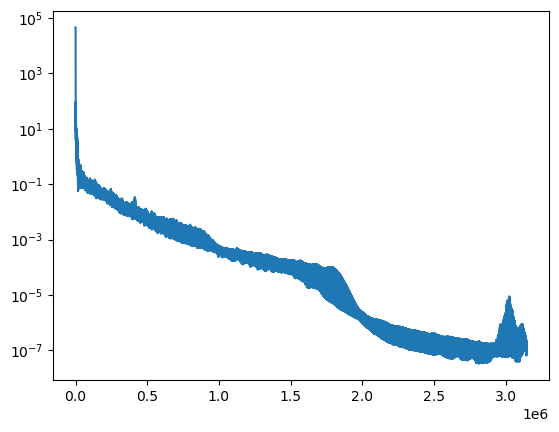

In [232]:
plt.plot(beammap)
plt.yscale("log")

In [107]:
beammap = gen_beammap(res, beam2d, target_pixel)
beammap_sym = gen_beammap(res, beam2d_sym, target_pixel)

bl = hp.anafast(beammap)
bl_sym = hp.anafast(beammap_sym);

blm = hp.map2alm(beammap)
blm_sym = hp.map2alm(beammap_sym);

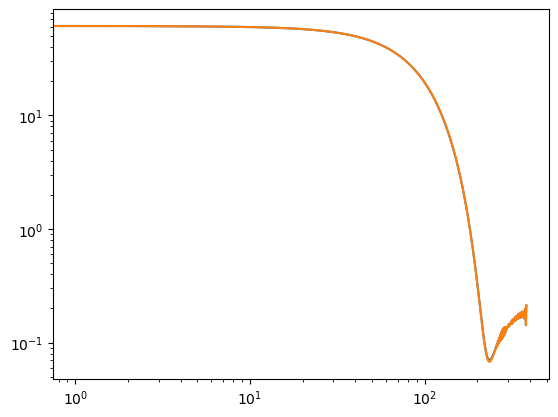

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc60a792580>

In [108]:
plt.loglog(abs.(bl))
plt.loglog(abs.(bl_sym))

In [41]:
lmax = 3*res.nside - 1
l, m = hp.Alm.getlm(lmax)
l = l .+ 1
m = m .+ 1;

In [42]:
blm[m]

73920-element Vector{ComplexF64}:
     7.826649654812504 + 0.0im
     7.826649654812504 + 0.0im
     7.826649654812504 + 0.0im
     7.826649654812504 + 0.0im
     7.826649654812504 + 0.0im
     7.826649654812504 + 0.0im
     7.826649654812504 + 0.0im
     7.826649654812504 + 0.0im
     7.826649654812504 + 0.0im
     7.826649654812504 + 0.0im
     7.826649654812504 + 0.0im
     7.826649654812504 + 0.0im
     7.826649654812504 + 0.0im
                       ⋮
  0.015036781252827048 + 0.0im
  0.015036781252827048 + 0.0im
  0.006895044234663688 + 0.0im
  0.006895044234663688 + 0.0im
  0.006895044234663688 + 0.0im
  0.006895044234663688 + 0.0im
  -0.01001476914418781 + 0.0im
  -0.01001476914418781 + 0.0im
  -0.01001476914418781 + 0.0im
 -0.004832159728856773 + 0.0im
 -0.004832159728856773 + 0.0im
  0.004831082053464481 + 0.0im

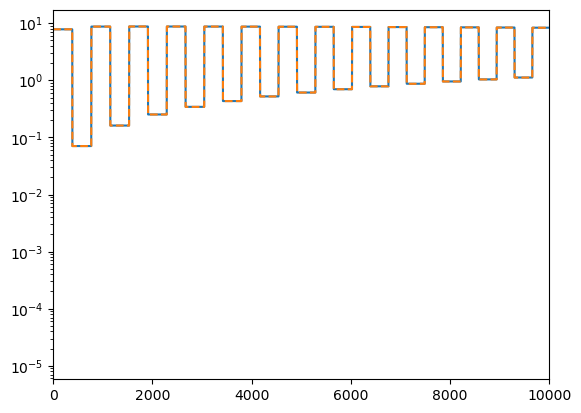

(0.0, 10000.0)

In [49]:
plt.plot(abs.(blm[m]))
plt.plot(abs.(blm_sym[m]), "--")
plt.yscale("log")
plt.xlim(0,10000)